<a href="https://www.kaggle.com/code/jainishsavaliya/time-series-forcasting-with-xgboost?scriptVersionId=191714406" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


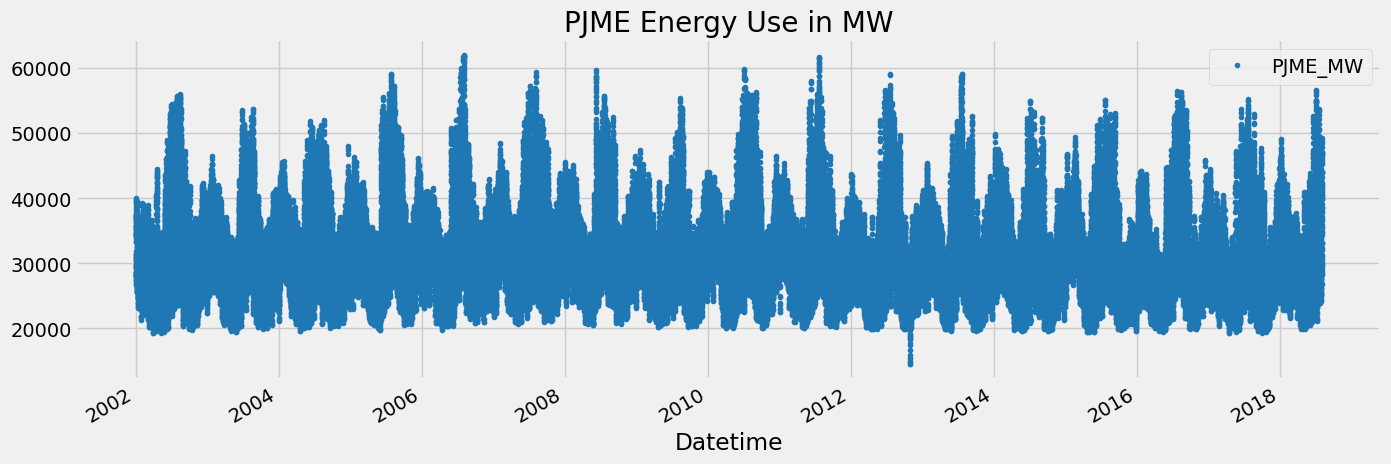

In [4]:
df.plot(
        style = '.',
        figsize = (15,5),
        color= color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

1.Outlier Analysis and removal

<Axes: ylabel='Frequency'>

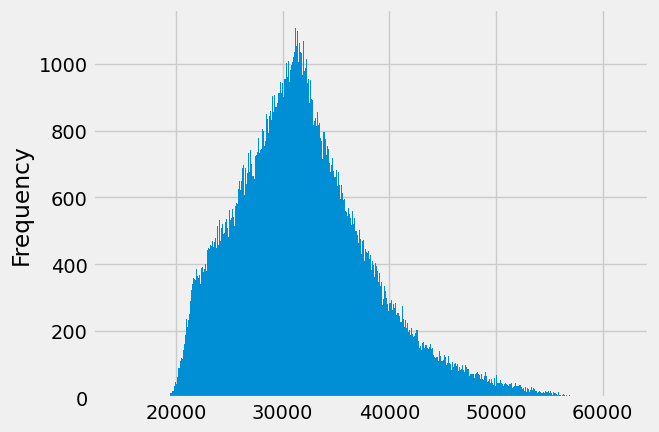

In [5]:
df['PJME_MW'].plot(kind= 'hist' , bins= 500)

In [6]:
#df.query('PJME_MW <19_000').plot(figsize = (15, 5), style= '.')

In [7]:
df = df.query('PJME_MW > 19_000').copy()


Reviewing: Train / Test Split

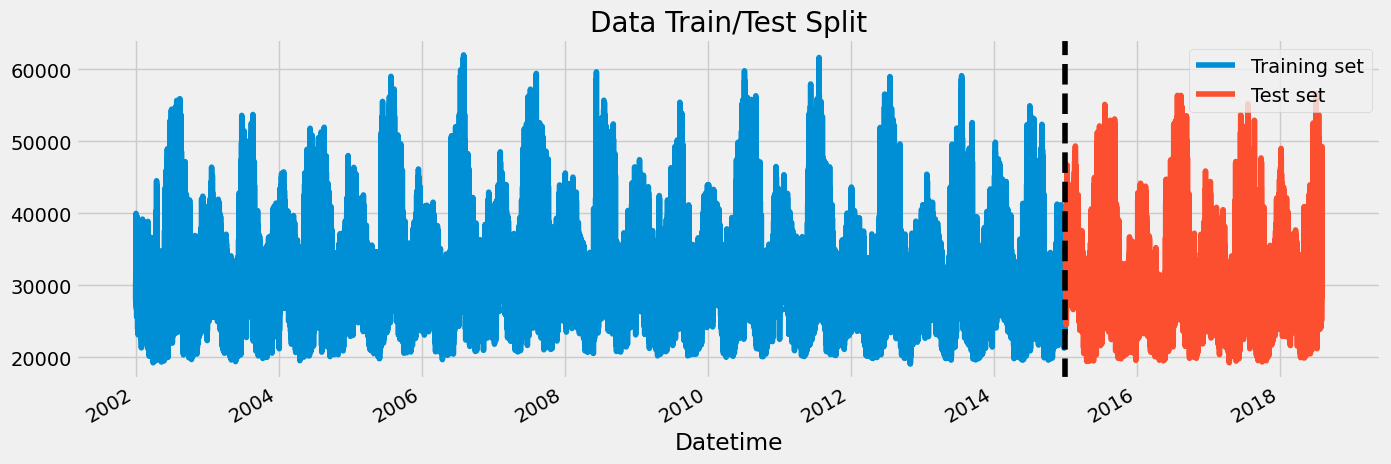

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label= 'Training set' , title = 'Data Train/Test Split')
test.plot(ax=ax, label= 'Test set')
ax.axvline('01-01-2015' , color= 'black' , ls='--')
ax.legend(['Training set' , 'Test set'])
plt.show()


**1.Time Series Cross Validaiton**

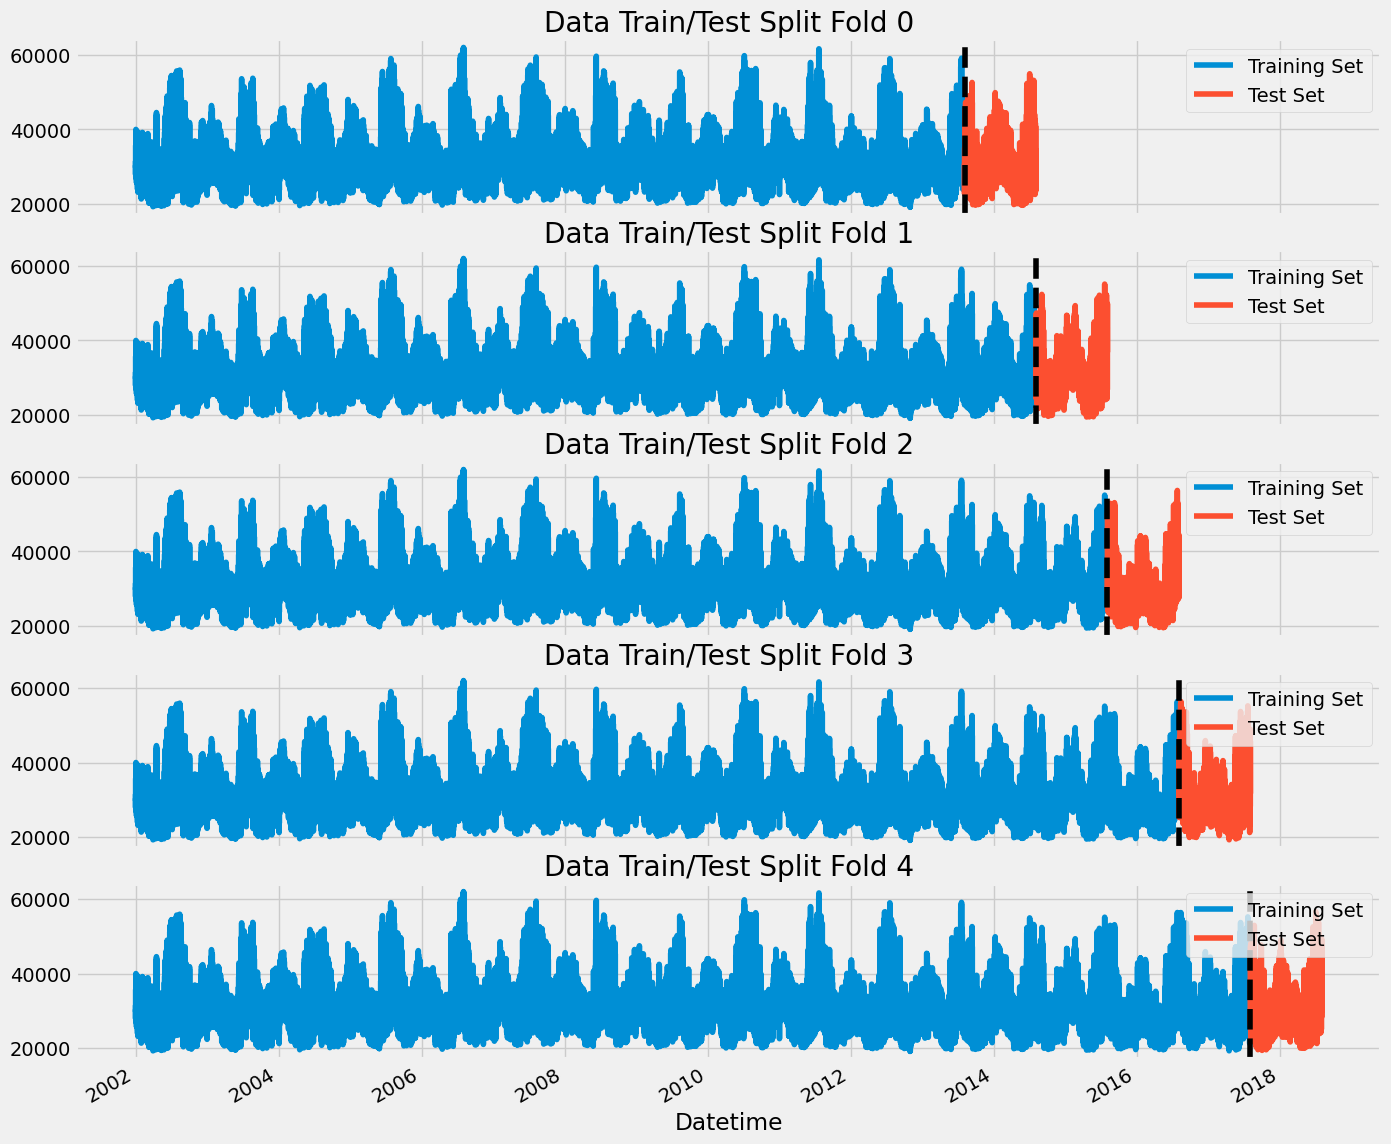

In [9]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Ensure tss is defined correctly
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

# Create subplots
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0

# Loop over each fold
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()  # Add legend to each subplot
    fold += 1

# Show the plot after the loop
plt.show()


**2.Forecasting Horizon Explained**

In [10]:
def create_features(df):
    """Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] =df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

**Lag Features**

In [11]:
def add_lags(df):
    target_map =df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [12]:
df = add_lags(df)

**Train Using Cross Validation**

In [13]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24*365*1, gap = 24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = [ 'dayofyear' , 'hour' , 'dayofweek' , 'quarter' , 'month' , 'year' , 'lag1' , 'lag2' , 'lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor (base_score = 0.5, booster = 'gbtree',
                            n_estimators = 1000,
                            early_stopping_rounds =50,
                            objective = 'reg:linear',
                            max_depth =3,
                            learning_rate = 0.01)
    reg.fit(X_train, y_train,
           eval_set = [(X_train, y_train), (X_test, y_test)],
           verbose = 100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.70202
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.22087
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.46419
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.32356
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.25535
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.36581	validation_1-rmse:12020.28283
[200]	validation_0-rmse:5738.57925	validation_1-rmse:5796.45874
[300]	validation_0-rmse:3918.53218	validation_1-rmse:4388.39477
[400]	validation_0-rmse:3501.24270	validation_1-rmse:4173.36380
[500]	validation_0-rmse:3384.02490	validation_1-rmse:4119.56538
[600]	validation_0-rmse:3325.50024	validation_1-rmse:4105.01446
[700]	validation_0-rmse:3282.73755	validation_1-rmse:4091.23557
[800]	validation_0-rmse:3250.37610	validation_1-rmse:4083.12690
[900]	validation_0-rmse:3223.87814	validation_1-rmse:4081.46154
[999]	validation_0-rmse:3199.82843	validation_1-rmse:4052.57120
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.87740	validation_1-rmse:11963.42706
[200]	validation_0-rmse:5752.44568	validation_1-rmse:5611.92884
[300]	validation_0-rmse:3951.51709	validation_1-rmse:4156.41403
[400]	validation_0-rmse:3539.25569	validation_1-rmse:4006.58873
[440]	validation_0-rmse:3479.88018	validation_1-rmse:4011.05271


In [14]:
print(f'Score across fold {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across fold 3742.5833
Fold scores:[3760.8277187583353, 3420.313091887879, 3478.018038580526, 4052.5712055405547, 4001.186553933809]


**Predicting the Future**

In [15]:
#Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear' , 'hour' , 'dayofweek' , 'quarter' , 'month' ,'year',
            'lag1' , 'lag2' , 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor (base_score = 0.5, booster = 'gbtree',
                            n_estimators = 500,
                            objective = 'reg:linear',
                            max_depth =3,
                            learning_rate = 0.01)

reg.fit(X_all, y_all,
           eval_set = [(X_all, y_all)],
           verbose = 100)

[0]	validation_0-rmse:32403.88991


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:38:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [16]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [17]:
#create future dataframe
future =pd.date_range('2018-08-03' , '2019-08-01' , freq = '1h')
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [18]:
future_w_features = df_and_future.query('isFuture').copy()

future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


## Predict the future

In [19]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

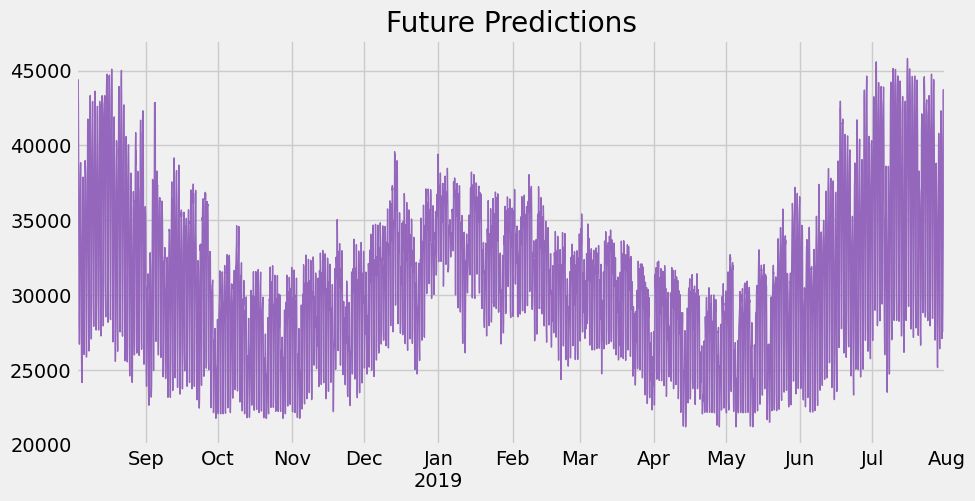

In [20]:
future_w_features['pred'].plot(figsize = (10,5), color = color_pal[4],
                              ms=1, lw=1, title = 'Future Predictions')

## Saving Model for Later

In [21]:
#save model
reg.save_model('model.json')


In [22]:
!ls -lh

total 560K
-rw-r--r-- 1 root root 559K Aug  8 23:38 model.json


<Axes: title={'center': 'Future Predictions'}>

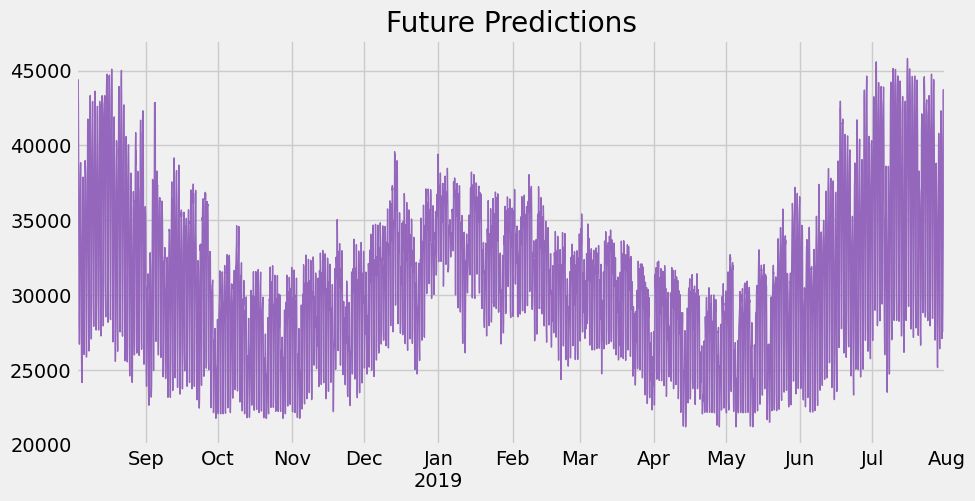

In [23]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'].plot(figsize = (10,5), color = color_pal[4],
                              ms=1, lw=1, title = 'Future Predictions')
